### I only show a slight improvement over simply choosing the dominant class (which was 84%, but 0 sensitivity).  The reviews have a lot of crossover between negative and positive, and it's especially difficult to pull out features that focus on negatives.  With another half day or day of work, I could parse through and find more features, but I'm sure there's a better way (NLP?)
### I got the numbers below from Logistic Regression, and almost exactly the same using Naive Bayes.  I also trained on resampled (50/50 positive/negative) data, in an attempt to improve the model.  It became much less accurate, but did increase sensitivity significantly.

#### Accuracy: 85.27%
#### Specificity: 99.19%
#### Sensitivity: 9.62%


In [26]:
import numpy as np
import pandas as pd
import gzip
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
pd.set_option('display.max_rows', 100)
#pd.set_option('display.max_colwidth', -1)

from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import BernoulliNB
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression

%matplotlib inline

In [2]:
# These functions were on the data source's site, for uncompressing and 
# loading the data into pandas.  I left the abysmal variable name choices as I found them...
def parse(path):
  g = gzip.open(path, 'rb')
  for l in g:
    yield eval(l)

    
def getDF(path):
  i = 0
  df = {}
  for d in parse(path):
    df[i] = d
    i += 1
  return pd.DataFrame.from_dict(df, orient='index')


In [3]:
revs = getDF('tools_home.json.gz')

In [4]:
revs.head(2)

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime
0,A4IL0CLL27Q33,104800001X,D. Brennan,"[0, 1]","I hate it when my shirt collars, not otherwise...",5.0,Perfect for collar stay management,1390953600,"01 29, 2014"
1,A3Q5W5E7TDVLJF,104800001X,funnyc130,"[0, 0]",These little magnets are really powerful for t...,5.0,Neat,1369958400,"05 31, 2013"


### Dropping the columns which aren't useful.  I'm keeping the product ID and summary to help see where reviews cluster for a given product, or possibly to help clarify an ambiguous review.

In [5]:
drop = ['reviewerID', 'reviewerName', 'helpful', 'unixReviewTime', 'reviewTime']
revs.drop(columns=drop, inplace=True)

In [6]:
revs.head(2)

,asin,reviewText,overall,summary
0,104800001X,"I hate it when my shirt collars, not otherwise...",5.0,Perfect for collar stay management
1,104800001X,These little magnets are really powerful for t...,5.0,Neat


### Ok, the dominant class is by far positive reviews (let's call 'positive' as 4.0 or greater).

In [7]:
revs['overall'].value_counts()

5.0    85266
4.0    28336
3.0    10769
1.0     5143
2.0     4962
Name: overall, dtype: int64

### Not missing any values

In [8]:
nans = revs.isnull().sum()
nans

asin          0
reviewText    0
overall       0
summary       0
dtype: int64

In [9]:
revs.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 134476 entries, 0 to 134475
Data columns (total 4 columns):
asin          134476 non-null object
reviewText    134476 non-null object
overall       134476 non-null float64
summary       134476 non-null object
dtypes: float64(1), object(3)
memory usage: 5.1+ MB


### Rename columns to make them clearer (at least to me)

In [10]:
revs.rename(columns={'asin':'item', 'reviewText':'text', 'overall':'neg_rev'}, inplace=True)

### Change this to binary, reviews 4.0 and above are positive (0), below are negative (1)

In [11]:
revs['neg_rev'] = np.where(revs['neg_rev'] >= 4, 0, 1)

In [34]:
#revs.loc[revs['neg_rev'] == 1, ['text']].head(4)

In [13]:
# This is for testing various words and phrases to see their distribution
# in both classes
revs.loc[revs['text'].str.contains(r"junk", case=False), :].groupby('neg_rev').count()

,item,text,summary
neg_rev,,,
0,743,743,743
1,578,578,578


In [14]:
words = ([r"\blove\b", "love"],
         [r"\bgreat\b", "great"],
         [r"\b(very)? easy (to use)?\b", "easy"],
         [r"\bworks? well\b", "works"],
         [r"\bnice\b", "nice"],
         [r"\bexcellent\b", "excellent"],
         [r"\bfine\b", "fine"],
         [r"\bhappy\b", "happy"],
         [r"\bquality\b", "quality"],
         [r"\bimpressed\b", "impressed"],
         [r"\bvalue\b", "value"],
         [r"\bgood\b", "good"],
         [r"\bhighly\b", "highly"],
         [r"\bprice\b", "price"],
         [r"\bbest\b", "best"],
         [r"\buseless\b", "useless"],
         [r"\breturn(ed)?\b", "return"],
         [r"\bvery disappointed\b", "disappoint"],
         [r"\bfav(orite)?", "favorite"],
         [r"\bunusable\b", "unusable"],
         [r"\bchina?(ese)?", "china"])

for pattern, word in words:
    revs[str(word)] = revs['text'].str.contains(pattern, case=False)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:25: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:25: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:25: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:25: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.


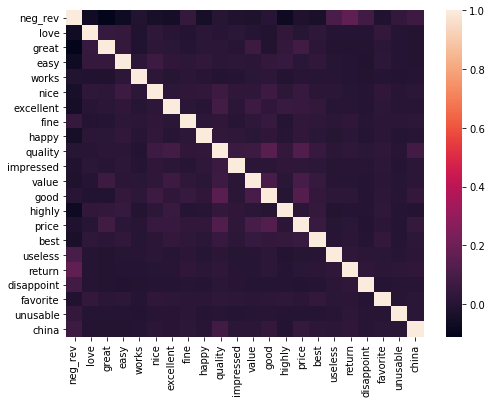

In [15]:
# Hardly any correlation at all
fig, ax = plt.subplots(figsize=(8,6))
sns.heatmap(revs.corr())
plt.show()

In [16]:
# Split into data and target
X = revs.loc[:, 'love':]
y = revs['neg_rev']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=43)

In [17]:
bnb = BernoulliNB()
bnb.fit(X_train, y_train)
predictions = bnb.predict(X_test)

In [18]:
print(confusion_matrix(y_test, predictions))
print('\n', classification_report(y_test, predictions))

[[33804   270]
 [ 5684   585]]

               precision    recall  f1-score   support

           0       0.86      0.99      0.92     34074
           1       0.68      0.09      0.16      6269

   micro avg       0.85      0.85      0.85     40343
   macro avg       0.77      0.54      0.54     40343
weighted avg       0.83      0.85      0.80     40343



In [19]:
revs.groupby('neg_rev').count()

,item,text,summary,love,great,easy,works,nice,excellent,fine,...,good,highly,price,best,useless,return,disappoint,favorite,unusable,china
neg_rev,,,,,,,,,,,,,,,,,,,,,
0,113602,113602,113602,113602,113602,113602,113602,113602,113602,113602,...,113602,113602,113602,113602,113602,113602,113602,113602,113602,113602
1,20874,20874,20874,20874,20874,20874,20874,20874,20874,20874,...,20874,20874,20874,20874,20874,20874,20874,20874,20874,20874


In [20]:
# I pulled this out of my old Naive Bayes model, another way to do evaluation; more verbose to be sure!
def evaluate(data, target, predicted):
    """
    Do all of the statistical evaluation of a classifier in one place.
    IN: the data being tested, target labels and predicted labels
    OUT: various tests, accuracy, specificity, sensitivity, and confusion matrix usage
    """
    
    total_points = data.shape[0]
    hits = (target == predicted).sum()
    misses = (target != predicted).sum()
    accuracy = (hits / data.shape[0]) * 100
    c_matr = confusion_matrix(target, predicted)
    real_ham = (target == False).sum()
    real_spam = (target == True).sum()
    specificity = (c_matr[0][0] / real_ham) * 100
    sensitivity = (c_matr[1][1] / real_spam) * 100
    
    print("Total data points in the set: {}".format(total_points))
    
    print("Correct: {} ({} true negatives and {} true positives)".format(
        hits, c_matr[0][0], c_matr[1][1]))
    
    print("Mislabeled: {} ({} Type I / false alarms and {} Type II / misses)".format(
        misses, c_matr[0][1], c_matr[1][0]))
    
    print(f"Real test data: negatives {real_ham} positives {real_spam}")  
    print(f"\nAccuracy: {accuracy:.2f}%\nSpecificity: {specificity:.2f}%\nSensitivity: {sensitivity:.2f}%")

In [21]:
evaluate(X_test, y_test, predictions)

Total data points in the set: 40343
Correct: 34389 (33804 true negatives and 585 true positives)
Mislabeled: 5954 (270 Type I / false alarms and 5684 Type II / misses)
Real test data: negatives 34074 positives 6269

Accuracy: 85.24%
Specificity: 99.21%
Sensitivity: 9.33%


### Pretty abysmal; time to resample and weight this more evenly.  I'm making a 50/50 split of negative and positive reviews, 20k total

In [22]:
# Make a more even split to train on
eq_sampling = pd.concat([revs.loc[revs['neg_rev'] == 1, :].sample(10000),
                         revs.loc[revs['neg_rev'] == 0, :].sample(10000)])

In [23]:
# take training data from my evenly split data
X = eq_sampling.loc[:, 'love':]
y = eq_sampling['neg_rev']
bnb.fit(X, y)
predictions = bnb.predict(X_test)

### An improvement in sensitivity, but a big loss overall!  Looks like the training data need to be improved, a lot.  These methods are just too coarse, and need real NLP.

In [24]:
print(confusion_matrix(y_test, predictions))
print('\n', classification_report(y_test, predictions))

[[19065 15009]
 [ 1766  4503]]

               precision    recall  f1-score   support

           0       0.92      0.56      0.69     34074
           1       0.23      0.72      0.35      6269

   micro avg       0.58      0.58      0.58     40343
   macro avg       0.57      0.64      0.52     40343
weighted avg       0.81      0.58      0.64     40343



In [25]:
evaluate(X_test, y_test, predictions)

Total data points in the set: 40343
Correct: 23568 (19065 true negatives and 4503 true positives)
Mislabeled: 16775 (15009 Type I / false alarms and 1766 Type II / misses)
Real test data: negatives 34074 positives 6269

Accuracy: 58.42%
Specificity: 55.95%
Sensitivity: 71.83%


### For grins, let's try a different model, Logistic Regression.

In [30]:
lr = LogisticRegression(C=1e9)
fit = lr.fit(X_train, y_train)

print('Coefficients')
print(fit.coef_)
print(fit.intercept_)
predictions = lr.predict(X_test)

print('\n Accuracy by admission status')
print(pd.crosstab(predictions, y_test))

print('\n Percentage accuracy')
print(lr.score(X_test, y_test))

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Coefficients
[[-0.78271756 -0.7706641  -0.63855029 -0.11129211 -0.3640463  -0.90698919
   0.39020884 -0.7763177   0.01969879 -0.21354169 -0.28577422  0.06266981
  -1.61395091 -0.07548732 -0.37313795  1.89830357  2.08256638  3.45153872
  -0.2388785   1.90366763  1.02301782]]
[-1.44234511]

 Accuracy by admission status
neg_rev      0     1
row_0               
0        33797  5666
1          277   603

 Percentage accuracy
0.8526881986961803


### The numbers are actually quite similar to Naive Bayes, both using the original data as well as the 50/50 data

In [31]:
# Original data here
evaluate(X_test, y_test, predictions)

Total data points in the set: 40343
Correct: 34400 (33797 true negatives and 603 true positives)
Mislabeled: 5943 (277 Type I / false alarms and 5666 Type II / misses)
Real test data: negatives 34074 positives 6269

Accuracy: 85.27%
Specificity: 99.19%
Sensitivity: 9.62%


### Below is Logistic Regression using the 50/50 training data; also worse, basically the same as the Naive Bayes on the same data

In [32]:
fit = lr.fit(X, y)

print('Coefficients')
print(fit.coef_)
print(fit.intercept_)
predictions = lr.predict(X_test)

print('\n Accuracy by admission status')
print(pd.crosstab(predictions, y_test))

print('\n Percentage accuracy')
print(lr.score(X_test, y_test))

Coefficients
[[-0.85037466 -0.80505102 -0.60702586 -0.03135053 -0.32159203 -0.87504495
   0.50446763 -0.6788178  -0.01550147 -0.01318161 -0.29232005  0.08471063
  -1.74435474 -0.03944309 -0.33030413  2.04650223  2.06511949  2.89840386
  -0.34529354  1.75480767  1.12124763]]
[0.22957896]

 Accuracy by admission status
neg_rev      0     1
row_0               
0        18906  1747
1        15168  4522

 Percentage accuracy
0.5807203232283171


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [33]:
evaluate(X_test, y_test, predictions)

Total data points in the set: 40343
Correct: 23428 (18906 true negatives and 4522 true positives)
Mislabeled: 16915 (15168 Type I / false alarms and 1747 Type II / misses)
Real test data: negatives 34074 positives 6269

Accuracy: 58.07%
Specificity: 55.49%
Sensitivity: 72.13%
